In [1]:
import xgboost as xgb
import os
import seaborn as sns
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score
from time import time
from scipy import stats
import joblib
import pickle
import pylab as plt
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, TimeSeriesSplit
import torch.nn as nn
import lightgbm as lgb
from utils import *
from xgboost import plot_importance
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
np.set_printoptions(suppress=True)
sns.set_style({'font.sans-serif': ['simhei', 'Arial']})   # 解决画图中文乱码

%matplotlib inline

In [2]:
data = pd.read_csv('./data.csv', encoding='GBK')
data.data_date = pd.to_datetime(data.data_date)
data.head(1)

,id,site_id,asin,data_date,product_title,ordered_revenue,ordered_revenue_of_total,ordered_revenue_last_year,ordered_units,ordered_units_of_total,ordered_units_prior_period,ordered_units_last_year,subcategory_sales_rank,average_sales_price,average_sales_price_prior_period,glance_views,change_in_glance_view_prior_period,change_in_gv_last_year,conversion_rate,rep_oos,rep_oos_of_total,rep_oos_prior_period,lbb_price,create_time,update_time
0,1,eb766123-9f24-436e-9117-49c739816794,B07GJBBGHG,2021-01-02,COSORI 5.8QT Electric Hot Air Fryers Oven Oill...,153827.1800,0.1300,1.2600,1284,0.0600,-0.1300,1.2600,1.0000,119.8000,0.0000,40220.0000,0.0000,1.1900,0.0300,0.0200,0.1400,0.1500,0.0000,2021/1/4 6:48,2021/1/4 6:48


In [3]:
alldata = data[(data.asin == 'B07T2LGN8P')][['data_date',
                                             'ordered_units']].sort_values('data_date')
alldata.shape

(619, 2)

In [4]:
alldata.head(3).append(alldata.tail(2))

,data_date,ordered_units
15975,2019-12-02,184
15938,2019-12-03,36
15903,2019-12-04,40
28666,2021-08-21,75
28849,2021-08-22,72


In [5]:
pd.date_range('2019-12-2', '2021-8-22').shape

(630,)

2019-12-2到2021-8-22一共是630天的数据，所以这里少了6天的数据

In [6]:
# 缺少了多少天的数据
set(pd.date_range('2019-12-2', '2021-8-22')).difference(set(alldata.data_date))

{Timestamp('2020-02-03 00:00:00', freq='D'),
 Timestamp('2020-02-04 00:00:00', freq='D'),
 Timestamp('2020-02-05 00:00:00', freq='D'),
 Timestamp('2020-05-09 00:00:00', freq='D'),
 Timestamp('2020-05-10 00:00:00', freq='D'),
 Timestamp('2020-05-11 00:00:00', freq='D'),
 Timestamp('2020-05-12 00:00:00', freq='D'),
 Timestamp('2021-01-27 00:00:00', freq='D'),
 Timestamp('2021-01-31 00:00:00', freq='D'),
 Timestamp('2021-02-01 00:00:00', freq='D'),
 Timestamp('2021-02-03 00:00:00', freq='D')}

In [7]:
# 每天的平均销量
alldata.ordered_units.mean()

57.21163166397415

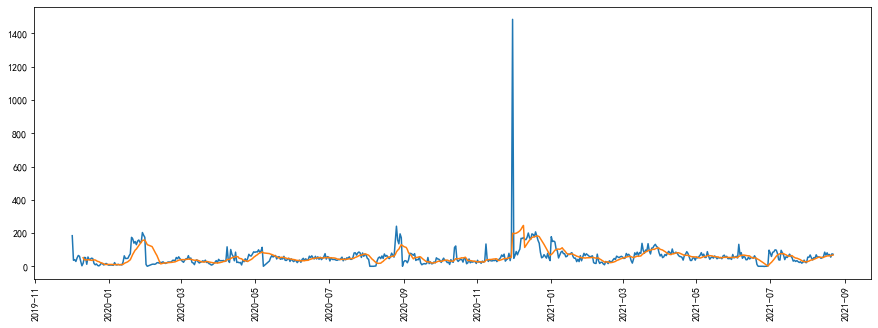

In [8]:
plt.figure(figsize=(15, 5))
plt.xticks(rotation=90)
plt.plot(alldata.data_date, alldata.ordered_units)
plt.plot(alldata.data_date, alldata.ordered_units.rolling(10).mean())

In [9]:
print(adfuller(alldata.ordered_units, 1))

(-13.011968351838403, 2.556743403968723e-24, 1, 617, {'1%': -3.440992973242412, '5%': -2.8662357332485353, '10%': -2.569270733669741}, 6933.320573424284)


序列平稳

In [10]:
roll_window = alldata.ordered_units.rolling(10, )

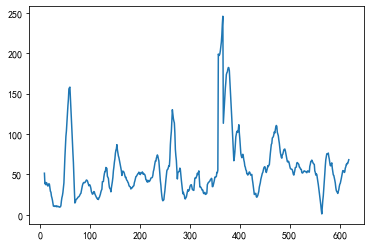

In [11]:
plt.plot(roll_window.mean().values)

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

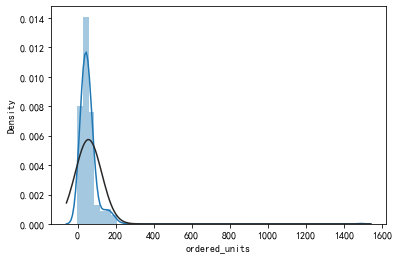

In [12]:
sns.distplot(alldata.ordered_units, fit=stats.norm)

In [13]:
# 偏度
alldata.ordered_units.skew()

14.313256816647634

In [14]:
from scipy.special import boxcox1p
boxcox1p(alldata.ordered_units, 0.21).skew()

-0.5363241647813696

<AxesSubplot:xlabel='ordered_units', ylabel='Density'>

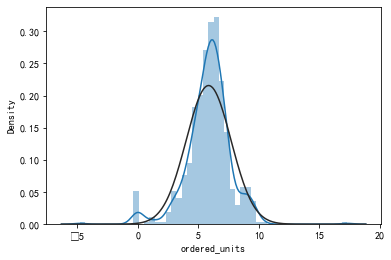

In [15]:
sns.distplot(boxcox1p(alldata.ordered_units, 0.21), fit=stats.norm)

## 数据预处理

### 异常值，删除小于等于0的数值和离群点

In [16]:
alldata[alldata.ordered_units <= 0].index

Int64Index([13870, 10363,  6937,  6895,  6853,  6810,  5847, 25206, 25265,
            25323, 25379, 25497, 25442, 25612, 25554],
           dtype='int64')

In [17]:
alldata.drop(alldata[alldata.ordered_units <= 0].index, inplace=True)

<AxesSubplot:xlabel='ordered_units'>

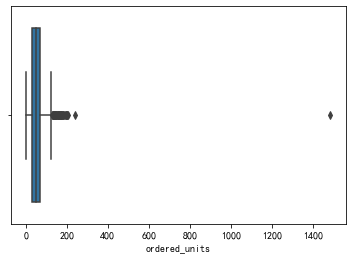

In [18]:
sns.boxplot(alldata.ordered_units)

In [19]:
alldata[alldata.ordered_units > 600].index

Int64Index([1682], dtype='int64')

In [20]:
alldata.drop(alldata[alldata.ordered_units > 600].index, inplace=True)

In [21]:
alldata.shape

(603, 2)

In [22]:
alldata.head(1)

,data_date,ordered_units
15975,2019-12-02,184


### 缺失值

In [23]:
alldata.isnull().sum()

data_date        0
ordered_units    0
dtype: int64

无缺失值不用处理

### 创造特征

In [24]:
def create_feature(df):
    # 添加权重特征
    df['weight'] = df.data_date.apply(lambda x: (
        x - pd.to_datetime('2019-12-02')).days)
    df['year'] = df.data_date.dt.year
    df['month'] = df.data_date.dt.month
    df['day'] = df.data_date.dt.day
    df['weekday'] = df.data_date.dt.weekday  # 周几
    df['quarter'] = df.data_date.dt.quarter  # 季度
    df['weekofyear'] = df.data_date.dt.weekofyear

    df.drop('data_date', axis=1, inplace=True)
    return df

In [25]:
alldata = create_feature(alldata)

In [26]:
alldata.head(3)

,ordered_units,weight,year,month,day,weekday,quarter,weekofyear
15975,184,0,2019,12,2,0,4,49
15938,36,1,2019,12,3,1,4,49
15903,40,2,2019,12,4,2,4,49


In [27]:
x = alldata.drop('ordered_units', axis=1)
y = alldata['ordered_units']
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=0, shuffle=False)

In [28]:
x_train.shape, x_test.shape

((542, 7), (61, 7))

In [29]:
x_train.head(2)

,weight,year,month,day,weekday,quarter,weekofyear
15975,0,2019,12,2,0,4,49
15938,1,2019,12,3,1,4,49


In [30]:
x_test.head(2)

,weight,year,month,day,weekday,quarter,weekofyear
24807,561,2021,6,15,1,2,24
24863,562,2021,6,16,2,2,24


### 编码

In [31]:
weight_cat = list(range(1000))
year_category = [2019, 2020, 2021, 2022]
month_category = list(range(1, 13))
day_category = list(range(1, 32))
weekday_cat = list(range(7))
quarter_cat = [1, 2, 3, 4]
weekofyear_cat = list(range(1, 54))

encoder = OneHotEncoder(sparse=False,
                        categories=[weight_cat, year_category, month_category,
                                    day_category, weekday_cat, quarter_cat, weekofyear_cat],
                        handle_unknown='error')

x_train = encoder.fit_transform(x_train)
x_test = encoder.transform(x_test)
x_train.shape, x_test.shape

((542, 1111), (61, 1111))

In [32]:
x_train = pd.DataFrame(x_train, columns=encoder.get_feature_names())
x_test = pd.DataFrame(x_test, columns=encoder.get_feature_names())
x_train.head(1)

,x0_0,x0_1,x0_2,x0_3,x0_4,x0_5,x0_6,x0_7,x0_8,x0_9,x0_10,x0_11,x0_12,x0_13,x0_14,x0_15,x0_16,x0_17,x0_18,x0_19,x0_20,x0_21,x0_22,x0_23,x0_24,x0_25,x0_26,x0_27,x0_28,x0_29,x0_30,x0_31,x0_32,x0_33,x0_34,x0_35,x0_36,x0_37,x0_38,x0_39,x0_40,x0_41,x0_42,x0_43,x0_44,x0_45,x0_46,x0_47,x0_48,x0_49,x0_50,x0_51,x0_52,x0_53,x0_54,x0_55,x0_56,x0_57,x0_58,x0_59,x0_60,x0_61,x0_62,x0_63,x0_64,x0_65,x0_66,x0_67,x0_68,x0_69,x0_70,x0_71,x0_72,x0_73,x0_74,x0_75,x0_76,x0_77,x0_78,x0_79,x0_80,x0_81,x0_82,x0_83,x0_84,x0_85,x0_86,x0_87,x0_88,x0_89,x0_90,x0_91,x0_92,x0_93,x0_94,x0_95,x0_96,x0_97,x0_98,x0_99,x0_100,x0_101,x0_102,x0_103,x0_104,x0_105,x0_106,x0_107,x0_108,x0_109,x0_110,x0_111,x0_112,x0_113,x0_114,x0_115,x0_116,x0_117,x0_118,x0_119,x0_120,x0_121,x0_122,x0_123,x0_124,x0_125,x0_126,x0_127,x0_128,x0_129,x0_130,x0_131,x0_132,x0_133,x0_134,x0_135,x0_136,x0_137,x0_138,x0_139,x0_140,x0_141,x0_142,x0_143,x0_144,x0_145,x0_146,x0_147,x0_148,x0_149,x0_150,x0_151,x0_152,x0_153,x0_154,x0_155,x0_156,x0_157,x0_158,x0_159,x0_160,x0_161,x0_162,x0_163,x0_164,x0_165,x0_166,x0_167,x0_168,x0_169,x0_170,x0_171,x0_172,x0_173,x0_174,x0_175,x0_176,x0_177,x0_178,x0_179,x0_180,x0_181,x0_182,x0_183,x0_184,x0_185,x0_186,x0_187,x0_188,x0_189,x0_190,x0_191,x0_192,x0_193,x0_194,x0_195,x0_196,x0_197,x0_198,x0_199,x0_200,x0_201,x0_202,x0_203,x0_204,x0_205,x0_206,x0_207,x0_208,x0_209,x0_210,x0_211,x0_212,x0_213,x0_214,x0_215,x0_216,x0_217,x0_218,x0_219,x0_220,x0_221,x0_222,x0_223,x0_224,x0_225,x0_226,x0_227,x0_228,x0_229,x0_230,x0_231,x0_232,x0_233,x0_234,x0_235,x0_236,x0_237,x0_238,x0_239,x0_240,x0_241,x0_242,x0_243,x0_244,x0_245,x0_246,x0_247,x0_248,x0_249,x0_250,x0_251,x0_252,x0_253,x0_254,x0_255,x0_256,x0_257,x0_258,x0_259,x0_260,x0_261,x0_262,x0_263,x0_264,x0_265,x0_266,x0_267,x0_268,x0_269,x0_270,x0_271,x0_272,x0_273,x0_274,x0_275,x0_276,x0_277,x0_278,x0_279,x0_280,x0_281,x0_282,x0_283,x0_284,x0_285,x0_286,x0_287,x0_288,x0_289,x0_290,x0_291,x0_292,x0_293,x0_294,x0_295,x0_296,x0_297,x0_298,x0_299,x0_300,x0_301,x0_302,x0_303,x0_304,x0_305,x0_306,x0_307,x0_308,x0_309,x0_310,x0_311,x0_312,x0_313,x0_314,x0_315,x0_316,x0_317,x0_318,x0_319,x0_320,x0_321,x0_322,x0_323,x0_324,x0_325,x0_326,x0_327,x0_328,x0_329,x0_330,x0_331,x0_332,x0_333,x0_334,x0_335,x0_336,x0_337,x0_338,x0_339,x0_340,x0_341,x0_342,x0_343,x0_344,x0_345,x0_346,x0_347,x0_348,x0_349,x0_350,x0_351,x0_352,x0_353,x0_354,x0_355,x0_356,x0_357,x0_358,x0_359,x0_360,x0_361,x0_362,x0_363,x0_364,x0_365,x0_366,x0_367,x0_368,x0_369,x0_370,x0_371,x0_372,x0_373,x0_374,x0_375,x0_376,x0_377,x0_378,x0_379,x0_380,x0_381,x0_382,x0_383,x0_384,x0_385,x0_386,x0_387,x0_388,x0_389,x0_390,x0_391,x0_392,x0_393,x0_394,x0_395,x0_396,x0_397,x0_398,x0_399,x0_400,x0_401,x0_402,x0_403,x0_404,x0_405,x0_406,x0_407,x0_408,x0_409,x0_410,x0_411,x0_412,x0_413,x0_414,x0_415,x0_416,x0_417,x0_418,x0_419,x0_420,x0_421,x0_422,x0_423,x0_424,x0_425,x0_426,x0_427,x0_428,x0_429,x0_430,x0_431,x0_432,x0_433,x0_434,x0_435,x0_436,x0_437,x0_438,x0_439,x0_440,x0_441,x0_442,x0_443,x0_444,x0_445,x0_446,x0_447,x0_448,x0_449,x0_450,x0_451,x0_452,x0_453,x0_454,x0_455,x0_456,x0_457,x0_458,x0_459,x0_460,x0_461,x0_462,x0_463,x0_464,x0_465,x0_466,x0_467,x0_468,x0_469,x0_470,x0_471,x0_472,x0_473,x0_474,x0_475,x0_476,x0_477,x0_478,x0_479,x0_480,x0_481,x0_482,x0_483,x0_484,x0_485,x0_486,x0_487,x0_488,x0_489,x0_490,x0_491,x0_492,x0_493,x0_494,x0_495,x0_496,x0_497,x0_498,x0_499,x0_500,x0_501,x0_502,x0_503,x0_504,x0_505,x0_506,x0_507,x0_508,x0_509,x0_510,x0_511,x0_512,x0_513,x0_514,x0_515,x0_516,x0_517,x0_518,x0_519,x0_520,x0_521,x0_522,x0_523,x0_524,x0_525,x0_526,x0_527,x0_528,x0_529,x0_530,x0_531,x0_532,x0_533,x0_534,x0_535,x0_536,x0_537,x0_538,x0_539,x0_540,x0_541,x0_542,x0_543,x0_544,x0_545,x0_546,x0_547,x0_548,x0_549,x0_550,x0_551,x0_552,x0_553,x0_554,x0_555,x0_556,x0_557,x0_558,x0_559,x0_560,x0_561,x0_562,x0_563,x0_564,x0_565,x0_566,x0_567,x0_568,x0_569,x0_570,x0_571,x0_572,x0_573,x0_574,x0_575,x0_576,x0_577,x0_578,x0_579,x0_580,x0_581,x0_582,x0_583,x0_584,x0_585,x0_586,

## 训练

### sklearn api

In [33]:
xgbr = XGBRegressor(n_estimators=200,
                    learning_rate=0.35,
                    max_depth=7,
                    subsample=0.6,
                    colsample_bytree=0.7,
                    objective='reg:squarederror',
                    base_score=0.5,
                    gamma=1,
                    n_jobs=8, verbosity=1)

In [50]:
ts = time()
kf = KFold()
print(cross_val_score(xgbr, x, y, cv=kf))
time() - ts

[-1.08727505 -0.62284209 -0.67834879  0.1296603  -0.90654244]


1.0123062133789062

In [35]:
ts = time()
tscv = TimeSeriesSplit(10)
print(cross_val_score(xgbr, x_train, y_train, cv=tscv))
time() - ts

[ 0.15229354 -0.11378831 -0.0240393  -0.30167316  0.15514399 -0.02710328
 -1.70187247 -6.23167406 -2.51231784 -5.08577544]


9.08997893333435

In [36]:
xgbr.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_test, y_test)],
         early_stopping_rounds=20, verbose=True)

[0]	validation_0-rmse:50.10013	validation_1-rmse:37.11776
[1]	validation_0-rmse:38.93416	validation_1-rmse:27.17632
[2]	validation_0-rmse:30.53163	validation_1-rmse:23.60552
[3]	validation_0-rmse:25.55728	validation_1-rmse:22.14870
[4]	validation_0-rmse:22.94454	validation_1-rmse:22.69012
[5]	validation_0-rmse:20.96527	validation_1-rmse:23.20544
[6]	validation_0-rmse:19.66760	validation_1-rmse:23.94553
[7]	validation_0-rmse:18.87854	validation_1-rmse:24.44458
[8]	validation_0-rmse:18.35975	validation_1-rmse:25.83478
[9]	validation_0-rmse:17.89619	validation_1-rmse:25.86450
[10]	validation_0-rmse:17.65109	validation_1-rmse:27.58106
[11]	validation_0-rmse:16.56949	validation_1-rmse:28.81100
[12]	validation_0-rmse:16.04318	validation_1-rmse:28.78241
[13]	validation_0-rmse:15.67709	validation_1-rmse:29.08022
[14]	validation_0-rmse:15.07801	validation_1-rmse:28.66223
[15]	validation_0-rmse:14.75414	validation_1-rmse:28.98612
[16]	validation_0-rmse:14.40889	validation_1-rmse:28.83747
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.35, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
             tree_method='exact', validate_parameters=1, verbosity=1)

In [37]:
# # 网格搜索
# # params_grid = {'learning_rate': np.arange(0, 1, 0.05)}

# # params_grid = {'max_depth': range(0, 8, 1)}

# # params_grid = {'subsample': np.arange(0, 1, 0.05)}
# params_grid = {'colsample_bytree': np.arange(0, 1, 0.05)}

# gridCV = GridSearchCV(xgbr, params_grid, cv=5, scoring='r2', n_jobs=8)

# ts = time()
# gridCV.fit(x_train, y_train)
# print(time() - ts)
# gridCV.best_params_, gridCV.best_score_

In [38]:
# result = xgbr.evals_result()
# plt.plot(result['validation_0']['rmse'])
# plt.plot(result['validation_1']['rmse'])

## 测试

### sklearn api

In [39]:
y_pred = xgbr.predict(x_test)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred),
                                                              metrics2(
                                                                  y_test, y_pred),
                                                              r2_score(y_test, y_pred)))

metrics1: 0.974
metrics2: 0.141
r2: 0.003


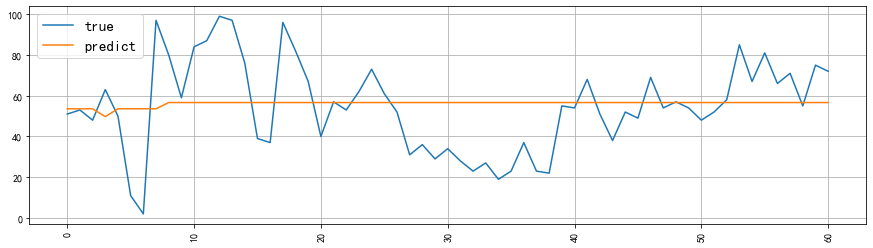

In [40]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend(fontsize=15)

In [41]:
date_pred = pd.DataFrame({'data_date': pd.date_range('2021-8-23', periods=30)})

In [42]:
create_feature(date_pred)

,weight,year,month,day,weekday,quarter,weekofyear
0,630,2021,8,23,0,3,34
1,631,2021,8,24,1,3,34
2,632,2021,8,25,2,3,34
3,633,2021,8,26,3,3,34
4,634,2021,8,27,4,3,34
5,635,2021,8,28,5,3,34
6,636,2021,8,29,6,3,34
7,637,2021,8,30,0,3,35
8,638,2021,8,31,1,3,35
9,639,2021,9,1,2,3,35


In [43]:
date_pred = encoder.transform(date_pred)

In [44]:
pred = xgbr.predict(date_pred)

In [45]:
pred

array([ 56.649796,  56.649796,  56.649796,  56.649796,  56.649796,
        56.649796,  56.649796, 100.54876 , 100.54876 , 100.54876 ,
       100.54876 , 100.54876 , 100.54876 , 100.54876 ,  56.649796,
        56.649796,  56.649796,  56.649796,  56.649796,  56.649796,
        56.649796,  56.649796,  56.649796,  56.649796,  56.649796,
        56.649796,  56.649796,  56.649796,  45.71966 ,  45.71966 ],
      dtype=float32)

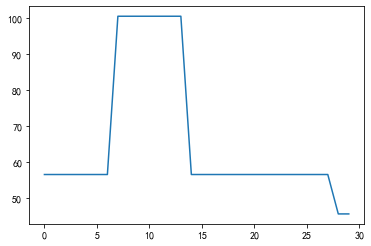

In [46]:
plt.plot(pred)

In [47]:
a = xgbr.get_booster().get_score(importance_type='gain')
# len(a)
sorted(a.items(), key=lambda x: x[1], reverse=True)

[('x6_35', 12937.027881666669),
 ('x2_12', 10705.67810738),
 ('x2_1', 7123.625945285715),
 ('x6_3', 6586.926106666667),
 ('x6_50', 6348.3757444),
 ('x6_1', 5935.9866950000005),
 ('x1_2019', 5925.33642088889),
 ('x6_53', 5555.813475000001),
 ('x0_268', 5538.914716666666),
 ('x6_4', 4655.070989999999),
 ('x5_2', 4607.23047),
 ('x6_51', 4413.467397333333),
 ('x6_2', 4320.776725357143),
 ('x2_2', 3436.141262377778),
 ('x0_391', 3338.40234),
 ('x1_2021', 3290.8977205000006),
 ('x1_2020', 3230.84892463),
 ('x6_32', 3201.8139650000003),
 ('x2_3', 3178.4381839999996),
 ('x6_5', 3102.10128825),
 ('x0_388', 3000.887695),
 ('x0_38', 2949.47852),
 ('x0_395', 2942.30469),
 ('x0_0', 2916.148085),
 ('x3_2', 2652.1453367999993),
 ('x0_365', 2624.69336),
 ('x6_42', 2622.625),
 ('x0_421', 2612.27344),
 ('x0_464', 2372.73438),
 ('x6_39', 2329.10352),
 ('x6_9', 2189.5388166666667),
 ('x6_19', 2156.936035),
 ('x0_463', 2151.96875),
 ('x0_392', 2028.76758),
 ('x0_266', 1958.1324198571426),
 ('x0_399', 1863.

### xgboost api

In [48]:
dtest = xgb.DMatrix(x_test, y_test)

In [49]:
y_pred = model.predict(dtest)
print('metrics1: {:.3f}\nmetrics2: {:.3f}\nr2: {:.3f}'.format(metrics1(y_test, y_pred),
                                                              metrics2(
                                                                  y_test, y_pred),
                                                              r2_score(y_test, y_pred)))

NameError: name 'model' is not defined

In [ ]:
plt.figure(figsize=(15, 4))
plt.plot(y_test.values, label='true')
plt.plot(y_pred, label='predict')
plt.xticks(rotation=90)
plt.grid()
plt.legend()

In [ ]:
model.get_score(importance_type='gain')

In [ ]:
xgb.to_graphviz(model, num_trees=0)

In [ ]:
import xgboost
from xgboost import XGBClassifier
from sklearn.datasets import load_iris

iris = load_iris()
x, y = iris.data, iris.target
model = XGBClassifier()
model.fit(x, y)
# 如果输入是没有表头的array,会自动以f1,f2开始,需要更换表头
# 画树结构图的时候也需要替换表头

model.get_booster().feature_names = iris.feature_names
# max_num_features指定排名最靠前的多少特征
# height=0.2指定柱状图每个柱子的粗细,默认是0.2
# importance_type='weight'默认是用特征子树中的出现次数(被选择次数),还有"gain"和"cover"
xgboost.plot_importance(model, max_num_features=5, importance_type='gain')

# f_score就是feature score
model.feature_importances_  # 这里的特征重要性就是gain进行归一化之后的值

In [ ]:
model.feature_importances_.sum()

In [ ]:
2.9918/(2.9918+1.3149+0.0727+0.0424)

In [ ]:
xgb.to_graphviz(model, num_trees=1)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dt = DecisionTreeClassifier(max_depth=2)

In [ ]:
dt.fit(x, y)

In [ ]:
import graphviz
from sklearn import tree
import pydotplus
from IPython.display import Image

In [ ]:
# 对于决策树来说，特征重要性就等于这个特征分裂的时候的总信息增益，这个特征有可能分裂，加到一起就行
dt.feature_importances_

In [ ]:
dot = tree.export_graphviz(dt)
graph = pydotplus.graph_from_dot_data(dot)
Image(graph.create_png())